# Mask RCNN

## Imports

In [ ]:
!python -m pip install roboflow
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=3cd5c7584bba7d9b1346e0fd1c670c4ad91aa66bea75f0dae09e5a505b8247e8
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.9
    Uninstalling pyparsing-3.0.9:
      Successfully uninstalled pyparsing-3.0.9
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
    

In [ ]:
import logging
import torch
from collections import OrderedDict
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2.utils.events import EventStorage
from detectron2.modeling import build_model
import detectron2.utils.comm as comm
from detectron2.engine import default_argument_parser, default_setup, default_writers, launch
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    COCOEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    inference_on_dataset,
    print_csv_format,
)

from roboflow import Roboflow

from matplotlib import pyplot as plt
from PIL import Image

# Download dataset via Roboflow pip package and show a sample annotation

In [ ]:
VERSION = 1

In [ ]:
rf = Roboflow(api_key="SeScyFeiR90djceO280o")
project = rf.workspace("aml-92lrc").project("mountain-skiers-duplicate")
dataset = project.version(VERSION).download("coco")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Mountain-Skiers-Duplicate-1 in coco:: 100%|██████████| 74/74 [00:00<00:00, 1872.98it/s]


In [ ]:
register_coco_instances("asl_poly_train", {}, f"./Mountain-Skiers-Duplicate-{VERSION}/train/_annotations.coco.json", f"./Mountain-Skiers-Duplicate-{VERSION}/train/")
register_coco_instances("asl_poly_valid", {}, f"./Mountain-Skiers-Duplicate-{VERSION}/valid/_annotations.coco.json", f"./Mountain-Skiers-Duplicate-{VERSION}/valid/")
register_coco_instances("asl_poly_test", {}, f"./Mountain-Skiers-Duplicate-{VERSION}/test/_annotations.coco.json", f"./Mountain-Skiers-Duplicate-{VERSION}/test/")

WARNING [04/27 14:12:14 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/27 14:12:14 d2.data.datasets.coco]: Loaded 57 images in COCO format from ./Mountain-Skiers-Duplicate-1/train/_annotations.coco.json


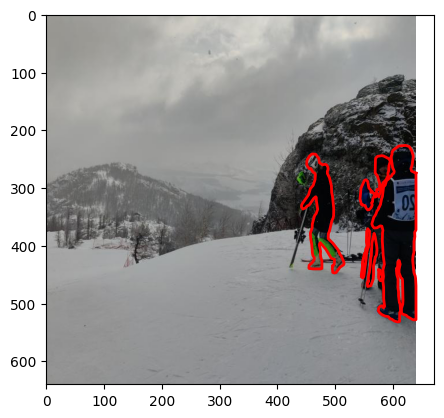

In [ ]:
dataset_train = DatasetCatalog.get("asl_poly_train")
fig, ax = plt.subplots()
dataset_dict = random.choice(dataset_train)
im = Image.open(dataset_dict['file_name'])
ax.imshow(im)
for ann in dataset_dict['annotations']:
    for poly in ann['segmentation']:
        x = poly[0::2]
        y = poly[1::2]
        ax.plot(x,y, linewidth=2, color='red')

## Training

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("asl_poly_train",)#Train dataset registered in a previous cell
cfg.DATASETS.TEST = ("asl_poly_test",)#Test dataset registered in a previous cell
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 10000 #We found that with a patience of 500, training will early stop before 10,000 iterations
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 27 # 26 letters plus one super class
cfg.TEST.EVAL_PERIOD = 0 # Increase this number if you want to monitor validation performance during training

PATIENCE = 500 #Early stopping will occur after N iterations of no imporovement in total_loss

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
def get_evaluator(cfg, dataset_name, output_folder=None):
    """
    Create evaluator(s) for a given dataset.
    This uses the special metadata "evaluator_type" associated with each builtin dataset.
    For your own dataset, you can simply create an evaluator manually in your
    script and do not have to worry about the hacky if-else logic here.
    """
    if output_folder is None:
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
    evaluator_list = []
    evaluator_type = MetadataCatalog.get(dataset_name).evaluator_type
    if evaluator_type in ["sem_seg", "coco_panoptic_seg"]:
        evaluator_list.append(
            SemSegEvaluator(
                dataset_name,
                distributed=True,
                output_dir=output_folder,
            )
        )
    if evaluator_type in ["coco", "coco_panoptic_seg"]:
        evaluator_list.append(COCOEvaluator(dataset_name, output_dir=output_folder))
    if evaluator_type == "coco_panoptic_seg":
        evaluator_list.append(COCOPanopticEvaluator(dataset_name, output_folder))
    if evaluator_type == "cityscapes_instance":
        return CityscapesInstanceEvaluator(dataset_name)
    if evaluator_type == "cityscapes_sem_seg":
        return CityscapesSemSegEvaluator(dataset_name)
    if evaluator_type == "pascal_voc":
        return PascalVOCDetectionEvaluator(dataset_name)
    if evaluator_type == "lvis":
        return LVISEvaluator(dataset_name, cfg, True, output_folder)
    if len(evaluator_list) == 0:
        raise NotImplementedError(
            "no Evaluator for the dataset {} with the type {}".format(dataset_name, evaluator_type)
        )
    if len(evaluator_list) == 1:
        return evaluator_list[0]
    return DatasetEvaluators(evaluator_list)

def do_test(cfg, model):
    results = OrderedDict()
    for dataset_name in cfg.DATASETS.TEST:
        data_loader = build_detection_test_loader(cfg, dataset_name)
        evaluator = get_evaluator(
            cfg, dataset_name, os.path.join(cfg.OUTPUT_DIR, "inference", dataset_name)
        )
        results_i = inference_on_dataset(model, data_loader, evaluator)
        results[dataset_name] = results_i
        if comm.is_main_process():
            logger.info("Evaluation results for {} in csv format:".format(dataset_name))
            print_csv_format(results_i)
    if len(results) == 1:
        results = list(results.values())[0]
    return results


logger = logging.getLogger("detectron2")
resume=False
model = build_model(cfg)
optimizer = build_optimizer(cfg, model)
scheduler = build_lr_scheduler(cfg, optimizer)

BEST_LOSS = np.inf

checkpointer = DetectionCheckpointer(
    model, cfg.OUTPUT_DIR, optimizer=optimizer, scheduler=scheduler, save_to_disk=True
)
start_iter = (
    checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, resume=resume).get("iteration", -1) + 1
)
prev_iter = start_iter
max_iter = cfg.SOLVER.MAX_ITER

periodic_checkpointer = PeriodicCheckpointer(
    checkpointer, cfg.SOLVER.CHECKPOINT_PERIOD, max_iter=max_iter
)

writers = default_writers(cfg.OUTPUT_DIR, max_iter) if comm.is_main_process() else []

# compared to "train_net.py", we do not support accurate timing and
# precise BN here, because they are not trivial to implement in a small training loop
data_loader = build_detection_train_loader(cfg)
logger.info("Starting training from iteration {}".format(start_iter))
patience_counter = 0
with EventStorage(start_iter) as storage:
    for data, iteration in zip(data_loader, range(start_iter, max_iter)):
        storage.iter = iteration

        loss_dict = model(data)
        losses = sum(loss_dict.values())
        assert torch.isfinite(losses).all(), loss_dict

        loss_dict_reduced = {k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        if comm.is_main_process():
            storage.put_scalars(total_loss=losses_reduced, **loss_dict_reduced)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        storage.put_scalar("lr", optimizer.param_groups[0]["lr"], smoothing_hint=False)
        scheduler.step()

        if (
            cfg.TEST.EVAL_PERIOD > 0
            and (iteration + 1) % cfg.TEST.EVAL_PERIOD == 0
            and iteration != max_iter - 1
        ):
            do_test(cfg, model)
            # Compared to "train_net.py", the test results are not dumped to EventStorage
            comm.synchronize()

        if iteration - start_iter > 5 and (
            (iteration + 1) % 20 == 0 or iteration == max_iter - 1
        ):
            for writer in writers:
                writer.write()
        periodic_checkpointer.step(iteration)
        
        if iteration > prev_iter:
            prev_iter = iteration
            if losses_reduced < BEST_LOSS:
                BEST_LOSS = losses_reduced
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter % 100 == 0:
                    print(f"Loss has not improved for {patience_counter} iterations")
                if patience_counter >= PATIENCE:
                    print(f"EARLY STOPPING")
                    break
                
do_test(cfg, model)

[04/27 14:48:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Studying/AML/Assignment2/model_final_f10217.pkl ...


roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


WARNING [04/27 14:48:33 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/27 14:48:33 d2.data.datasets.coco]: Loaded 57 images in COCO format from ./Mountain-Skiers-Duplicate-1/train/_annotations.coco.json
[04/27 14:48:33 d2.data.build]: Removed 1 images with no usable annotations. 56 images left.
[04/27 14:48:33 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/27 14:48:33 d2.data.build]: Using training sampler TrainingSampler
[04/27 14:48:33 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[04/27 14:48:33 d2.data.common]: Serializing 56 elements to byte tensors and concatenating them all ...
[04/27 14:48:33 d2.data.common]: Serialized dataset takes 0.32 MiB
[04/27 14:48:33 detectron2]: Starting training from iteration

OrderedDict([('bbox',
              {'AP': 35.21196800424135,
               'AP50': 59.21819142698583,
               'AP75': 40.832585822684834,
               'APs': 30.08405840584058,
               'APm': 49.938904604746185,
               'APl': 59.306930693069305,
               'AP-humans': nan,
               'AP-human': 0.0,
               'AP-skater': 57.26072607260726,
               'AP-skier': 48.375177940116785}),
             ('segm',
              {'AP': 33.943068919403615,
               'AP50': 59.21819142698583,
               'AP75': 32.30806413974731,
               'APs': 26.05463879721305,
               'APm': 46.51627662766277,
               'APl': 58.34158415841584,
               'AP-humans': nan,
               'AP-human': 0.0,
               'AP-skater': 56.61881188118812,
               'AP-skier': 45.210394877022715})])

Evaluation results for segm: 

|   mAP   |  mAP50  |  mAP75  |  mAPs   |  mAPm   |  mAPl   |
|:-------:|:-------:|:-------:|:-------:|:-------:|:-------:|
| 0.33943 | 0.59218 | 0.32308 | 0.26055 | 0.46516 | 0.58342 |

mAP for the model is 0.34. It has the problem with rare **human** class (0 mAP).

Per-category segm AP: 

| category   | AP     |
|:-----------|:-------|
| skier     | 45.210   |
| human      | 0.000 |
| skater     | 56.619 |

# Test model and show example output

# Yolov8

In [6]:
!mkdir ./datasets
%cd ./datasets

# !pip install roboflow --quiet

/content/datasets/datasets


In [2]:
!pip install ultralytics==8.0.28

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.28 🚀 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.3/78.2 GB disk)


In [3]:
from ultralytics import YOLO

from IPython.display import display, Image

In [8]:
from roboflow import Roboflow

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="SeScyFeiR90djceO280o")
project = rf.workspace("aml-92lrc").project("mountain-skiers-duplicate")
dataset = project.version(1).download("yolov8")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics<=8.0.20 is required but found version=8.0.28, to fix: `pip install ultralytics<=8.0.20`


Extracting Dataset Version Zip to Mountain-Skiers-Duplicate-1 in yolov8:: 100%|██████████| 144/144 [00:00<00:00, 2218.39it/s]


In [ ]:
!yolo task=segment mode=train model=yolov8n-seg.pt data={dataset.location}/data.yaml epochs=20 imgsz=640

In [23]:
!yolo task=segment mode=train model=/content/datasets/datasets/runs/segment/train3/weights/best.pt data={dataset.location}/data.yaml epochs=20 imgsz=640

Ultralytics YOLOv8.0.28 🚀 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=segment, mode=train, model=/content/datasets/datasets/runs/segment/train3/weights/best.pt, data=/content/datasets/datasets/Mountain-Skiers-Duplicate-1/data.yaml, epochs=20, patience=50, batch=16, imgsz=640, save=True, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript,

In [10]:
from IPython.display import display, Image

## Testing

In [24]:
!yolo task=segment mode=val model=/content/datasets/datasets/runs/segment/train4/weights/best.pt data={dataset.location}/data.yaml

2023-04-27 19:11:47.163760: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 19:11:48.362194: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.28 🚀 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258649 parameters, 0 gradients, 12.0 GFLOPs
val: Scanning /content/datasets/datasets/Mountain-Skiers-Duplicate-1/valid/labels.cache... 5 images, 0 backgrounds, 0 corrupt: 100% 5/5 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 1/1 [00:00<00:00,  2.18it/s]
                   all          5         20      0.852      0.454    

I obtained mAP score of 0.455

# Conclusion

Yolov8 has better mAP (0.455 and 0.34 for Mask RCNN)

Yolov8 has size of 6.46 mb and Mask RCNN has 170 mb which is 26 times bigger.

Yolov8: `14.6ms inference`

Mask RCNN: `Total inference time: 0:00:00.131040`

Mask RCNN is 10 times slower tham Yolov8.

So, Yolov8 is better in all parameters.